# Applying variational inference on HD Gaussian process
prepared by Moses Chan, October 6 2022

In [1]:
import os
import sys
print('making sure I know where I am..', os.getcwd())
sys.path.insert(0, r'./tests/')

import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'grid'])
plt.rcParams.update({'font.size': 14,
                     'lines.markersize': 12})

gpcolor = r'#7b3294'
gpshade = r'#c2a5cf'
vicolor = r'#008837'
vishade = r'#a6dba0'


import torch
import numpy as np

from func2d import forrester2008

making sure I know where I am.. C:\Users\moses\Desktop\git\VIGP\code\gpVIIP


## Say we are given some data (2-dimensional)

In [2]:
# Set my noise level
noise = 0.5

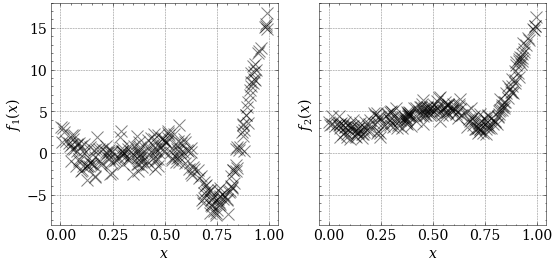

In [3]:
n = 250
x = np.random.uniform(0, 1, n)
# x = np.linspace(0, 1, n)

np.random.seed(150)
torch.manual_seed(1)

f = forrester2008(x, noisy=True, noiseconst=noise)

x = torch.tensor(x).unsqueeze(1)
f = torch.tensor(f)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for j in [0, 1]:
#     ax[j].plot(x0, f0[j], lw=2, alpha=0.2, color='gray')
    ax[j].scatter(x, f[j], marker='x', color='k', label=noise, alpha=0.5)
    ax[j].set_ylabel('$f_{:d}(x)$'.format(j+1))
    ax[j].set_xlabel('$x$')
plt.tight_layout()
# plt.legend(title='noise multiplier')

## 2D function for illustration comes from Forrester et al. (2008) (with modification)

In [4]:
# reference x

n0 = 100
x0 = np.linspace(0, 1, n0)

f0 = forrester2008(x0, noisy=False, noiseconst=0)

x0 = torch.tensor(x0).unsqueeze(1)
f0 = torch.tensor(f0)

## What if I just build a (Principal Component) GP over the data?

- A quick reminder of what the model looks like:
$$ f(x) = \Phi g(x) + \epsilon,  \quad \epsilon \sim N(0, \sigma^2) $$

$$ g_k(x) \sim \mathsf{GP}(0, c(\cdot, \cdot)) $$

- Arrange the data into an $n \times p$ matrix:
$$ F = (f(x_1)^\mathsf{T}, \ldots, f(x_n)^\mathsf{T})^\mathsf{T} $$

- Projection to an $n \times \kappa, \kappa \ll p$ matrix via $\Phi$:
$$ G_{n \times \kappa} = F_{n \times p} \Phi_{p \times \kappa} $$

- Use each column $G_k$ to train a GP.

In [5]:
from test_general import test_single

DIR = ""

emu, emumean, emustd, emupcto, \
        n, xtr, ftr, xte, fte = test_single(method='surmise', n=n, seed=0, noiseconst=noise,
                                            ftr=f, xtr=x, fte=f0, xte=x0,
                                            fte0=f0, output_csv=False, dir=DIR,
                                            return_quant=True)

emuub = (emumean + 2 * emustd)
emulb = (emumean - 2 * emustd)

PCGPwM considering  2 PCs


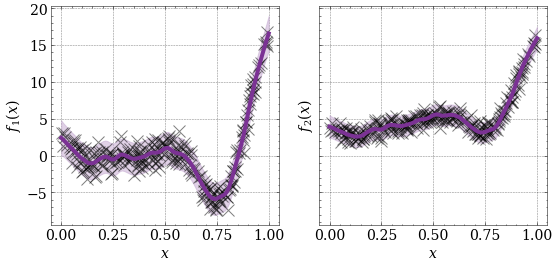

In [6]:
# PCGP plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for i in [0, 1]:
    axes[i].fill_between(xte.squeeze(), emulb[i].T, emuub[i].T, color=gpshade, alpha=0.5)
    axes[i].scatter(x=xtr, y=ftr[i], color='k', marker='x', label='Data', alpha=0.5)
    axes[i].plot(xte, emumean[i].T, label='GP', color=gpcolor, lw=4)
    axes[i].set_xlabel(r'$x$')

    axes[i].set_ylabel(r'$f_{:d}(x)$'.format(i+1))

plt.tight_layout()


### Let's take a peek at the true function

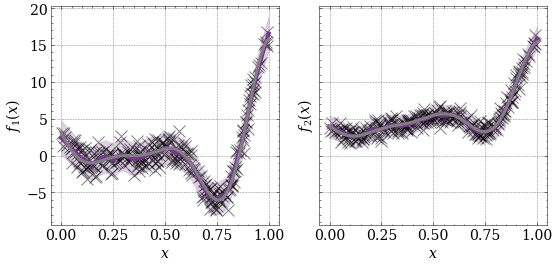

In [7]:
for j in [0, 1]:
    axes[j].plot(x0, f0[j], lw=3, color='gray')
fig

### Here I am trying a mysterious model

In [8]:
from test_general import test_single
model, predmean, confstd, Phi,\
        _, _, _, _, _ = test_single(method='MVGP', n=n, seed=0, 
                                    noiseconst=noise,
                                    ftr=f, xtr=x, fte=f0, xte=x0, 
                                    fte0=f0, output_csv=False, dir=DIR,
                                    return_quant=True)
predaddvar = model.predictaddvar().detach().numpy()
predstd = np.sqrt((confstd ** 2).T + predaddvar).T

txPhi = model.Phi * model.pcw 
Fs = model.tx_F(txPhi @ model.M)

confub = (predmean + 2 * confstd)
conflb = (predmean - 2 * confstd)
predub = (predmean + 2 * predstd)
predlb = (predmean - 2 * predstd)

#PCs: 2, recovery mse: 6.343E-31
iter  grad.absmax() pgrad.absmax() lr           negelbo      diff.       
1     48.363       7.335E+01    5.516E-03    240.337      inf         
2     33.274       3.172E-01    4.000E-01    196.199      44.138      
3     81.339       8.721E-02    1.600E+00    139.048      57.151      
4     75.463       2.958E-01    8.000E-01    69.916       69.132      
5     79.299       1.250E+00    2.000E-01    28.211       41.705      
6     39.102       7.954E-01    8.000E-01    -28.384      56.594      
7     23.530       8.863E-01    8.000E-01    -50.761      22.377      
8     12.035       8.277E-01    4.000E-01    -54.663      3.903       
9     5.246        1.481E+00    4.000E-01    -58.244      3.581       
exit after epoch 10, PGTOL <= 1.000E+00


In [9]:
model.lsigma2
model.lLmb

Parameter containing:
tensor([[-1.0889, -0.3627],
        [-0.6921, -0.1067]], requires_grad=True)

In [10]:
ip = 2
ip_frac = 1/ip
modelsp, predmeansp, confstdsp, Phisp, \
        _, _, _, _, _ = test_single(method='MVIP', n=n, ip_frac=ip_frac, seed=0, 
                                    noiseconst=noise,
                                    ftr=f, xtr=x, fte=f0, xte=x0,
                                    fte0=f0, output_csv=False, dir=DIR,
                                    return_quant=True)
predaddvarsp = modelsp.predictaddvar().detach().numpy()
predstdsp = np.sqrt((confstdsp ** 2).T + predaddvarsp).T

txPhisp = modelsp.Phi * modelsp.pcw 
Fssp = modelsp.tx_F(txPhisp @ modelsp.M)

confubsp = (predmeansp + 2 * confstdsp)
conflbsp = (predmeansp - 2 * confstdsp)
predubsp = (predmeansp + 2 * predstdsp)
predlbsp = (predmeansp - 2 * predstdsp)

#PCs: 2, recovery mse: 6.343E-31
exit after epoch 10, PGTOL <= 1.000E+00


In [11]:
modelsp.lsigma2

Parameter containing:
tensor(-3.0739, requires_grad=True)

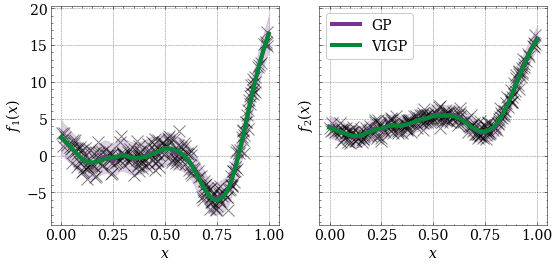

In [12]:
# With VIGP
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for i in [0, 1]:
    axes[i].fill_between(xte.squeeze(), emulb[i].T, emuub[i].T, color=gpshade, alpha=0.5)
    axes[i].fill_between(xte.squeeze(), conflb[i].T, confub[i].T, color=vishade, alpha=0.5)
    axes[i].scatter(x=xtr, y=ftr[i], color='k', marker='x', alpha=0.5)
    axes[i].plot(xte, emumean[i].T, label='GP', color=gpcolor, lw=4)
    axes[i].plot(xte, predmean[i].T, label='VIGP', color=vicolor, lw=4)
    
#     axes[i].scatter(x=xtr, y=F_s[i], color='r', marker='D', s=25, label='Smoothed data')
    
#     axes[i].plot(x0, f0[i], color='white', lw=4, alpha=0.7)
    
    axes[i].set_xlabel(r'$x$')
    axes[i].set_ylabel(r'$f_{:d}(x)$'.format(i+1))
#     axes[i].set_title('$f_{:d}$'.format(i+1))

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.tight_layout()

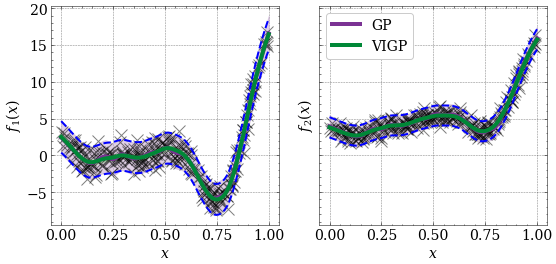

In [13]:
for i in [0, 1]:
    axes[i].plot(xte, predub[i].T, label='Full VI', color='b', linestyle='--', linewidth=2)
    axes[i].plot(xte, predlb[i].T, label='Full VI', color='b', linestyle='--', linewidth=2)
    
    axes[i].plot(xte, predubsp[i].T,  label='IP, $n={:d}p$'.format(ip), color='skyblue', linestyle='--', linewidth=2)
    axes[i].plot(xte, predlbsp[i].T,  label='IP, $n={:d}p$'.format(ip), color='skyblue', linestyle='--', linewidth=2)

fig

In [14]:
model.parameter_clamp(model.lLmb, model.lsigma2, model.lnugGPs, model.ltau2GPs)

(tensor([[-1.2244, -0.4415],
         [-0.8199, -0.1312]], grad_fn=<PermuteBackward0>),
 tensor(-2.8032, grad_fn=<AddBackward0>),
 tensor([-8.2740, -8.3708], grad_fn=<AddBackward0>),
 tensor([1.9935, 1.9633], grad_fn=<AddBackward0>))

In [15]:
modelsp.parameter_clamp(modelsp.lLmb, modelsp.lsigma2, modelsp.lnugGPs, modelsp.ltau2GPs)

(tensor([[-1.3930, -0.1353],
         [-0.0246,  0.3292]], grad_fn=<PermuteBackward0>),
 tensor(-2.7093, grad_fn=<AddBackward0>),
 tensor([-14.0070, -13.9686], grad_fn=<AddBackward0>),
 tensor([ 0.6495, -0.2148], grad_fn=<AddBackward0>))

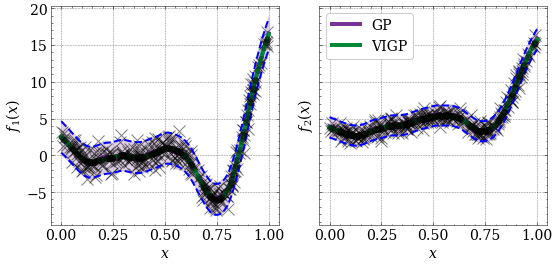

In [16]:
for i in [0, 1]:
    axes[i].scatter(x=xtr, y=Fs[i], color='k', marker='.', alpha=0.25, zorder=10)
#     axes[i].scatter(x=xtr, y=Fssp[i], color='skyblue', marker='s', s=35, label='Smoothed data, IP')

fig

### Where do the smooth dots come from?
Recall we have the data $F$, and we project onto some orthogonalized data $G$,

$$ G_{n \times \kappa} = F_{n \times p} \Phi_{p \times \kappa}. $$

If we know that $F$ is noisy, we expect that $G$ will also be noisy.

### Distribution of $G$
What if we assume that $G$ follows some distribution, for instance,

$$ G_{ik} \sim^{\mathrm{ind}} N(M_{ik}, V_{ik}). \tag{*} $$

Then we are looking for some posterior $p(G~|~F)$.  Now we have the typical posterior

$$ p(G~|~F) = \frac{p(F~|~G)p(G)}{p(F)} \propto \underbrace{p(F~|~G)p(G)}_{\text{if MCMC}}.  $$ 

### Variational inference (very brief) primer 
Say we don't use MCMC at all. 
Then an approximation of the posterior could be a member of some distributional family $q$ such that 

$$ q(G; \psi^\star) \approx p(G~|~F). $$

If we use eq. $(*)$ as our proposed family, then 
$$ q(G; (M, V)) = \prod_{i=1}^n\prod_{k=1}^\kappa \frac{1}{\sqrt{2\pi V_{ik}}} \exp{\left\{-\frac{1}{2 V_{ik}}  (G_{ik} - M_{ik})^2 \right\}} $$

To find this member, we optimize
\begin{align*}
    \psi^{\star} &= {\arg\min}_{\psi} \mathsf{KL}(q( G; \psi)~\|~p( G~|~ F)) \\
    &= {\arg\max}_\psi \mathsf{ELBO} \\
    &= {\arg\max}_\psi \mathbb{E}_q[\log p(F, G) - \log q(G; \psi)].
\end{align*}

### The real reason variational inference seems daunting (half kidding)
\begin{align*}
    \mathsf{ELBO} = \mathrm{const} &- \frac{nm}{2}\log(\sigma^2) - \frac{1}{2\sigma^2} \|\mathrm{vec}(F^\mathsf{T}) - (I_n \otimes \Phi) \mathrm{vec}({\color{blue} M}^\mathsf{T})\|^2 \tag{residual}\\ 
    & + \sum_{k=1}^\kappa \left(-\frac{1}{2}\log |C_k| - \frac{1}{2}{\color{blue} M_k}^\mathsf{T} C_k^{-1} {\color{blue} M_k} \right) \tag{GPs}\\ 
    & + \frac{1}{2}\sum_{i=1}^n \sum_{k=1}^\kappa \left( \frac{(\Phi^\mathsf{T} \Phi)_{kk}}{\sigma^2} {\color{blue} V}_{ik} - {\color{blue} V}_{ik}\left(C^{-1}_k\right)_{ii} + \log ({\color{blue} V}_{ik}) \right) \tag{???????} \\
\end{align*}

### If we take the hyperparameter of GPs to be fixed, then
\begin{align*}
    \hat{M}_k &= \underbrace{\left( I_n + \sigma^2  C_k^{-1}\right)^{-1}}_{\text{this is the smoother!}}  G_k, \\
    \hat{V}_k &= \left(\mathrm{diag}\left(\frac{1}{\sigma^2}  I_n +  C_k^{-1}\right)\right)^{-1}. \\
\end{align*}

### If there is time, try with increasing noise.